# Assignment 8: XAI in LLMs

Kelly Tong

Link to Colab: https://colab.research.google.com/drive/1iZNzjZxPN0iwKYZ_UsmlpKBdtYl2k8iZ#scrollTo=RYXsWwdpzfvi

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kelly0604/Assignment8_XAI_inLLMs/blob/main/Assignment8_XAI_inLLMs.ipynb)

### Preparation

In [ ]:
# Link to Github
!git clone https://github.com/Kelly0604/Assignment6_Explainable_TechniquesII.git
%cd /content/Assignment6_Explainable_TechniquesII
%ls
# update
!git pull

In [1]:
pip install torch transformers

In [4]:
# import necessary packages
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

### Modeling

In [5]:
# Load a gpt2 model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
# Prompt
prompt = "The assignment for this week is using XAI methods and applying them to prompts. These methods may include saliency score, perturbation and counterfactuals."

The prompt above is mannually written and does not have a source. The information is not perceived as 100% accurate. It is just for examining the generated text from gpt-2 model and the saliency score test.

In [7]:
# Tokenize the input and get input IDs
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

In [11]:
# Set pad_token_id to avoid warnings
model.config.pad_token_id = model.config.eos_token_id

# Generate text based on the prompt
with torch.no_grad():
    generated_outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=60,
        num_return_sequences=1,
        pad_token_id=model.config.eos_token_id
    )
generated_text = tokenizer.decode(generated_outputs[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)


Generated Text:
The assignment for this week is using XAI methods and applying them to prompts. These methods may include saliency score, perturbation and counterfactuals.

The next step is to use the XAI method to determine whether a given prompt is a positive or negative response. The X


### First sight explanation:

GPT-2 is a very original LLM which does not provide very great responses without much tuning. The responses (when length is set above 60) seems to be repeatetive, hence the max length here is set to 60.

The fact that the generated text has signals on `next step` suggests that the generated text might be influenced by contexts provided in `assignment` and `methods` which both might require taking steps. Also some of the generated texts tend to be repeating words in the input prompt, such as `XAI method` and `prompt`. More of the details can be analyzed with the saliency score below.

### Calculating Saliency Score

In [12]:
# Get embeddings
embeddings = model.transformer.wte(input_ids)
embeddings.retain_grad()

# Forward pass
outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
logits = outputs.logits

# Select the log-probability of the last token in the sequence as our "output"
log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
target_token_log_probs = log_probs[:, -1, :].max(dim=1).values

# Backward pass
target_token_log_probs.backward()

# Calculate saliency scores as the norm of the gradients for each embedding
saliency = embeddings.grad.abs().sum(dim=-1).squeeze(0)

# Normalize saliency scores for readability
normalized_saliency = saliency / saliency.sum()

# Decode the tokens back to words for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
saliency_scores = list(zip(tokens, normalized_saliency.detach().cpu().numpy()))

# Output
print("\nSaliency Scores:")
for token, score in saliency_scores:
    print(f"Token: {token}, Saliency Score: {score:.4f}")


Saliency Scores:
Token: The, Saliency Score: 0.0575
Token: Ġassignment, Saliency Score: 0.0647
Token: Ġfor, Saliency Score: 0.0570
Token: Ġthis, Saliency Score: 0.0436
Token: Ġweek, Saliency Score: 0.0370
Token: Ġis, Saliency Score: 0.0502
Token: Ġusing, Saliency Score: 0.0256
Token: ĠX, Saliency Score: 0.0209
Token: AI, Saliency Score: 0.0396
Token: Ġmethods, Saliency Score: 0.0483
Token: Ġand, Saliency Score: 0.0473
Token: Ġapplying, Saliency Score: 0.0257
Token: Ġthem, Saliency Score: 0.0138
Token: Ġto, Saliency Score: 0.0268
Token: Ġprompts, Saliency Score: 0.0296
Token: ., Saliency Score: 0.0633
Token: ĠThese, Saliency Score: 0.0195
Token: Ġmethods, Saliency Score: 0.0237
Token: Ġmay, Saliency Score: 0.0183
Token: Ġinclude, Saliency Score: 0.0242
Token: Ġsal, Saliency Score: 0.0178
Token: iency, Saliency Score: 0.0181
Token: Ġscore, Saliency Score: 0.0176
Token: ,, Saliency Score: 0.0253
Token: Ġpert, Saliency Score: 0.0305
Token: urb, Saliency Score: 0.0133
Token: ation, Salienc

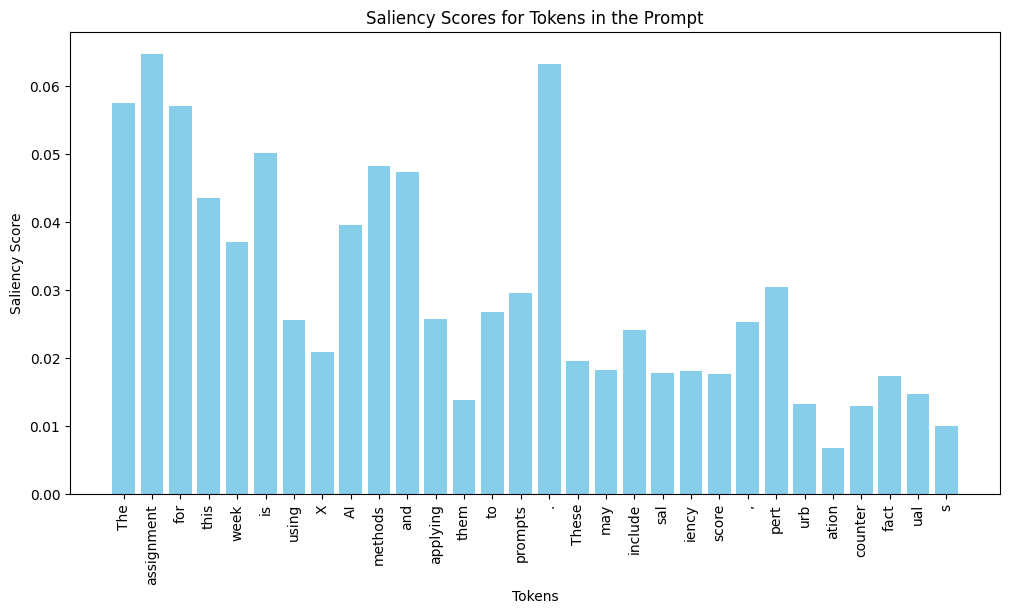

In [13]:
import matplotlib.pyplot as plt

# Tokens and their corresponding saliency scores
tokens = ["The", "assignment", "for", "this", "week", "is", "using", "X", "AI", "methods", "and",
          "applying", "them", "to", "prompts", ".", "These", "methods", "may", "include",
          "sal", "iency", "score", ",", "pert", "urb", "ation", "and", "counter", "fact", "ual", "s", "."]
saliency_scores = [0.0575, 0.0647, 0.0570, 0.0436, 0.0370, 0.0502, 0.0256, 0.0209, 0.0396, 0.0483,
                   0.0473, 0.0257, 0.0138, 0.0268, 0.0296, 0.0633, 0.0195, 0.0237, 0.0183, 0.0242,
                   0.0178, 0.0181, 0.0176, 0.0253, 0.0305, 0.0133, 0.0068, 0.0208, 0.0129, 0.0174,
                   0.0147, 0.0100, 0.0581]

# Plotting the saliency scores
plt.figure(figsize=(12, 6))
plt.bar(tokens, saliency_scores, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Tokens")
plt.ylabel("Saliency Score")
plt.title("Saliency Scores for Tokens in the Prompt")
plt.show()

### Explanation of Saliency Score

`High Saliency Tokens:`

- The tokens assignment (0.0647), The (0.0575), and the punctuation . (0.0633 and 0.0581) are some of the most influential tokens in the prompt. The word "assignment" likely signals the prompt’s academic or task-related nature, impacting the model's understanding of the context.
- High scores on punctuation (.) can occur because punctuation often denotes the end of a sentence, helping the model interpret sentence structure.

`Moderate Saliency Tokens: `

- Words like methods (0.0483), is (0.0502), and for (0.0570) have moderate saliency, helping define the task (“using XAI methods”), providing context without adding specific detail.

`Lower Saliency Tokens:`

- Tokens such as X (0.0209), them (0.0138), and parts of compound words like counter (0.0129) and fact (0.0174) have lower saliency scores. These tokens add specificity but aren't as central to the task description's core meaning.
- The fragmented scores on words like saliency score and perturbation are likely due to the tokenization splitting these words, leading to each part having a lower individual impact.

In the plot, the specific words such as “assignment,” “The,” “methods,” and punctuation “.” stand out with higher saliency scores, suggesting they are key to the model's understanding of the prompt. Words with lower scores contribute less individually, often being parts of longer, compound words or secondary context details.